# Deep Q-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import tensorflow as tf
import numpy as np

>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

In [2]:
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
rewards, states, actions, dones = [], [], [], []
for _ in range(10):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    states.append(state)
    rewards.append(reward)
    actions.append(action)
    dones.append(done)
    print('state, action, reward, done, info')
    print(state, action, reward, done, info)
    if done:
        print('state, action, reward, done, info')
        print(state, action, reward, done, info)
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        dones.append(done)

state, action, reward, done, info
[ 0.04696451 -0.17221028  0.03796082  0.26677635] 0 1.0 False {}
state, action, reward, done, info
[ 0.04352031  0.02234991  0.04329635 -0.01369588] 1 1.0 False {}
state, action, reward, done, info
[ 0.04396731  0.21682505  0.04302243 -0.29241007] 1 1.0 False {}
state, action, reward, done, info
[0.04830381 0.02111693 0.03717423 0.01352516] 0 1.0 False {}
state, action, reward, done, info
[ 0.04872615  0.21568658  0.03744473 -0.26720097] 1 1.0 False {}
state, action, reward, done, info
[ 0.05303988  0.41025468  0.03210071 -0.54784236] 1 1.0 False {}
state, action, reward, done, info
[ 0.06124497  0.6049113   0.02114386 -0.83024088] 1 1.0 False {}
state, action, reward, done, info
[ 0.0733432   0.79973795  0.00453905 -1.1161997 ] 1 1.0 False {}
state, action, reward, done, info
[ 0.08933796  0.99480003 -0.01778495 -1.40745533] 1 1.0 False {}
state, action, reward, done, info
[ 0.10923396  1.1901381  -0.04593405 -1.7056446 ] 1 1.0 False {}


To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [4]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
(10,) (10, 4) (10,) (10,)
float64 float64 int64 bool
1 0
2
1.0 1.0
1.1901381027294264 -1.7056445975251582


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [5]:
def model_input(state_size):
    # Given data
    states = tf.placeholder(tf.float32, [None, state_size], name=None)
    actions = tf.placeholder(tf.int32, [None], name=None)

    # Target Q values for training
    targetQs = tf.placeholder(tf.float32, [None], name=None)
    return states, actions, targetQs

In [6]:
def generator(states, hidden_size, action_size, reuse=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        #bn1 = tf.layers.batch_normalization(h1, training=training)
        nl1 = tf.maximum(0.01 * h1, h1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        #bn2 = tf.layers.batch_normalization(h2, training=training)
        nl2 = tf.maximum(0.01 * h2, h2)
        
        # Output layer
        logits = tf.layers.dense(nl2, action_size)
        # out = tf.tanh(logits)

        return logits

In [7]:
def model_loss(states, hidden_size, actions, action_size, targetQs):
    # Output layer
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)        

    # One hot encode the actions to later choose the Q-value for the action
    actions_labels = tf.one_hot(actions, action_size)

    # Train with loss (targetQ - Q)^2
    Qs = tf.reduce_sum(tf.multiply(actions_logits, actions_labels), axis=1)

    # error backpropagation: loss and opt
    loss = tf.reduce_mean(tf.square(targetQs - Qs))
    
    return actions_logits, Qs, loss

In [11]:
class DQN:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):
        
        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs, self.loss = model_loss(action_size=action_size, actions=self.actions, 
                                                      states=self.states, hidden_size=hidden_size, 
                                                      targetQs=self.targetQs)

        # Update the model: backward pass and backprop
        self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [12]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [13]:
train_episodes = 1000          # max number of episodes to learn from
max_steps = 400               # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64              # number of units in each Q-network hidden layer -- simulation
state_size = 4                # number of units for the input state/observation -- simulation
action_size = 2               # number of units for the output actions -- simulation

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
learning_rate = 0.001

In [14]:
tf.reset_default_graph()
model = DQN(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [15]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

# init memory
memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    # Episode is done/failed or not;
    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [16]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting
rewards_list = []
loss_list = []

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Training episodes/epochs
    step = 0
    for ep in range(train_episodes):
        
        # Env/agent steps/batches/minibatches
        total_reward = 0
        loss = 0
        t = 0
        while t < max_steps:
            step += 1
            
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from DQN
                feed_dict = {model.states: state.reshape((1, *state.shape))}
                actions_logits = sess.run(model.actions_logits, feed_dict)
                action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            # Cumulative reward
            total_reward += reward
            
            # Episode/epoch training is done/failed!
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p))
                
                # total rewards and losses for plotting
                rewards_list.append((ep, total_reward))
                loss_list.append((ep, loss))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            next_actions_logits = sess.run(model.actions_logits, feed_dict={model.states: next_states})

            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            next_actions_logits[episode_ends] = (0, 0)

            # Bellman equation
            targetQs = rewards + (gamma * np.max(next_actions_logits, axis=1))

            # Updating the model
            loss, _ = sess.run([model.loss, model.opt],
                                feed_dict={model.states: states,
                                           model.targetQs: targetQs,
                                           model.actions: actions})
    # Save the trained model 
    saver.save(sess, "checkpoints/DQN-cartpole.ckpt")

Episode: 0 Total reward: 11.0 Training loss: 1.0519 Explore P: 0.9989
Episode: 1 Total reward: 9.0 Training loss: 1.1393 Explore P: 0.9980
Episode: 2 Total reward: 61.0 Training loss: 4.6604 Explore P: 0.9920
Episode: 3 Total reward: 17.0 Training loss: 6.5942 Explore P: 0.9903
Episode: 4 Total reward: 10.0 Training loss: 7.4357 Explore P: 0.9894
Episode: 5 Total reward: 17.0 Training loss: 5.8803 Explore P: 0.9877
Episode: 6 Total reward: 35.0 Training loss: 26.5238 Explore P: 0.9843
Episode: 7 Total reward: 14.0 Training loss: 22.3601 Explore P: 0.9829
Episode: 8 Total reward: 10.0 Training loss: 12.9103 Explore P: 0.9820
Episode: 9 Total reward: 13.0 Training loss: 86.5051 Explore P: 0.9807
Episode: 10 Total reward: 26.0 Training loss: 109.5589 Explore P: 0.9782
Episode: 11 Total reward: 55.0 Training loss: 18.7798 Explore P: 0.9729
Episode: 12 Total reward: 9.0 Training loss: 286.2477 Explore P: 0.9720
Episode: 13 Total reward: 12.0 Training loss: 416.0462 Explore P: 0.9708
Episode

Episode: 116 Total reward: 28.0 Training loss: 14.9954 Explore P: 0.7202
Episode: 117 Total reward: 11.0 Training loss: 15.1714 Explore P: 0.7195
Episode: 118 Total reward: 35.0 Training loss: 1636.3499 Explore P: 0.7170
Episode: 119 Total reward: 26.0 Training loss: 24.8897 Explore P: 0.7151
Episode: 120 Total reward: 79.0 Training loss: 24.2551 Explore P: 0.7096
Episode: 121 Total reward: 56.0 Training loss: 345.2301 Explore P: 0.7057
Episode: 122 Total reward: 67.0 Training loss: 34.4412 Explore P: 0.7010
Episode: 123 Total reward: 14.0 Training loss: 535.6432 Explore P: 0.7001
Episode: 124 Total reward: 22.0 Training loss: 19.2218 Explore P: 0.6986
Episode: 125 Total reward: 65.0 Training loss: 44.0157 Explore P: 0.6941
Episode: 126 Total reward: 47.0 Training loss: 578.6313 Explore P: 0.6909
Episode: 127 Total reward: 13.0 Training loss: 707.5094 Explore P: 0.6900
Episode: 128 Total reward: 22.0 Training loss: 55.0313 Explore P: 0.6885
Episode: 129 Total reward: 17.0 Training loss

Episode: 226 Total reward: 199.0 Training loss: 17.0723 Explore P: 0.2031
Episode: 227 Total reward: 199.0 Training loss: 46.6727 Explore P: 0.1993
Episode: 228 Total reward: 199.0 Training loss: 7.3523 Explore P: 0.1956
Episode: 229 Total reward: 199.0 Training loss: 26.2174 Explore P: 0.1919
Episode: 230 Total reward: 195.0 Training loss: 33.2948 Explore P: 0.1884
Episode: 231 Total reward: 197.0 Training loss: 1467.4583 Explore P: 0.1849
Episode: 232 Total reward: 199.0 Training loss: 8.4197 Explore P: 0.1815
Episode: 233 Total reward: 199.0 Training loss: 18.8690 Explore P: 0.1781
Episode: 234 Total reward: 160.0 Training loss: 6.6724 Explore P: 0.1754
Episode: 235 Total reward: 199.0 Training loss: 6.9519 Explore P: 0.1722
Episode: 236 Total reward: 181.0 Training loss: 31.2450 Explore P: 0.1693
Episode: 237 Total reward: 199.0 Training loss: 7.9332 Explore P: 0.1661
Episode: 238 Total reward: 161.0 Training loss: 11.6169 Explore P: 0.1636
Episode: 239 Total reward: 199.0 Training

Episode: 338 Total reward: 177.0 Training loss: 0.7946 Explore P: 0.0367
Episode: 339 Total reward: 150.0 Training loss: 0.3999 Explore P: 0.0363
Episode: 340 Total reward: 127.0 Training loss: 0.3347 Explore P: 0.0360
Episode: 341 Total reward: 199.0 Training loss: 0.1645 Explore P: 0.0355
Episode: 342 Total reward: 151.0 Training loss: 0.3709 Explore P: 0.0351
Episode: 343 Total reward: 157.0 Training loss: 0.6917 Explore P: 0.0347
Episode: 344 Total reward: 173.0 Training loss: 4.0543 Explore P: 0.0343
Episode: 345 Total reward: 188.0 Training loss: 0.2724 Explore P: 0.0339
Episode: 346 Total reward: 160.0 Training loss: 0.2449 Explore P: 0.0335
Episode: 347 Total reward: 157.0 Training loss: 0.7854 Explore P: 0.0331
Episode: 348 Total reward: 169.0 Training loss: 161.7895 Explore P: 0.0327
Episode: 349 Total reward: 121.0 Training loss: 72.7227 Explore P: 0.0324
Episode: 350 Total reward: 9.0 Training loss: 126.1578 Explore P: 0.0324
Episode: 351 Total reward: 11.0 Training loss: 1

Episode: 449 Total reward: 12.0 Training loss: 299.3280 Explore P: 0.0304
Episode: 450 Total reward: 7.0 Training loss: 325.9603 Explore P: 0.0304
Episode: 451 Total reward: 7.0 Training loss: 349477.1875 Explore P: 0.0304
Episode: 452 Total reward: 11.0 Training loss: 890.3284 Explore P: 0.0303
Episode: 453 Total reward: 9.0 Training loss: 549.8304 Explore P: 0.0303
Episode: 454 Total reward: 8.0 Training loss: 1343.4952 Explore P: 0.0303
Episode: 455 Total reward: 11.0 Training loss: 790.6155 Explore P: 0.0303
Episode: 456 Total reward: 10.0 Training loss: 640.9414 Explore P: 0.0303
Episode: 457 Total reward: 9.0 Training loss: 371.3831 Explore P: 0.0302
Episode: 458 Total reward: 8.0 Training loss: 866.3584 Explore P: 0.0302
Episode: 459 Total reward: 10.0 Training loss: 555735.3125 Explore P: 0.0302
Episode: 460 Total reward: 12.0 Training loss: 806.8957 Explore P: 0.0302
Episode: 461 Total reward: 10.0 Training loss: 874.1885 Explore P: 0.0302
Episode: 462 Total reward: 11.0 Train

Episode: 559 Total reward: 15.0 Training loss: 188.5600 Explore P: 0.0168
Episode: 560 Total reward: 19.0 Training loss: 406.1046 Explore P: 0.0168
Episode: 561 Total reward: 14.0 Training loss: 679.6149 Explore P: 0.0168
Episode: 562 Total reward: 8.0 Training loss: 575.6674 Explore P: 0.0168
Episode: 563 Total reward: 54.0 Training loss: 207.6866 Explore P: 0.0167
Episode: 564 Total reward: 47.0 Training loss: 1018.0990 Explore P: 0.0167
Episode: 565 Total reward: 38.0 Training loss: 193.9419 Explore P: 0.0167
Episode: 566 Total reward: 25.0 Training loss: 286.2581 Explore P: 0.0166
Episode: 567 Total reward: 22.0 Training loss: 204.8205 Explore P: 0.0166
Episode: 568 Total reward: 18.0 Training loss: 1415.7516 Explore P: 0.0166
Episode: 569 Total reward: 13.0 Training loss: 452.1561 Explore P: 0.0166
Episode: 570 Total reward: 18.0 Training loss: 513.7568 Explore P: 0.0166
Episode: 571 Total reward: 17.0 Training loss: 361.0032 Explore P: 0.0166
Episode: 572 Total reward: 45.0 Train

Episode: 672 Total reward: 8.0 Training loss: 796.1838 Explore P: 0.0117
Episode: 673 Total reward: 11.0 Training loss: 747.1562 Explore P: 0.0117
Episode: 674 Total reward: 10.0 Training loss: 800.8413 Explore P: 0.0117
Episode: 675 Total reward: 9.0 Training loss: 104769.8672 Explore P: 0.0117
Episode: 676 Total reward: 12.0 Training loss: 2439.5854 Explore P: 0.0117
Episode: 677 Total reward: 9.0 Training loss: 3274.0630 Explore P: 0.0117
Episode: 678 Total reward: 10.0 Training loss: 2719.0620 Explore P: 0.0116
Episode: 679 Total reward: 8.0 Training loss: 1922.8391 Explore P: 0.0116
Episode: 680 Total reward: 9.0 Training loss: 2377.1157 Explore P: 0.0116
Episode: 681 Total reward: 9.0 Training loss: 3350.4551 Explore P: 0.0116
Episode: 682 Total reward: 8.0 Training loss: 4488.3638 Explore P: 0.0116
Episode: 683 Total reward: 10.0 Training loss: 682863.0625 Explore P: 0.0116
Episode: 684 Total reward: 7.0 Training loss: 4408.8779 Explore P: 0.0116
Episode: 685 Total reward: 10.0 

Episode: 786 Total reward: 8.0 Training loss: 511889.1875 Explore P: 0.0107
Episode: 787 Total reward: 10.0 Training loss: 4623.7344 Explore P: 0.0107
Episode: 788 Total reward: 9.0 Training loss: 1410862.6250 Explore P: 0.0107
Episode: 789 Total reward: 8.0 Training loss: 5998.5166 Explore P: 0.0107
Episode: 790 Total reward: 8.0 Training loss: 4092.2942 Explore P: 0.0107
Episode: 791 Total reward: 11.0 Training loss: 1138.6924 Explore P: 0.0107
Episode: 792 Total reward: 10.0 Training loss: 1211136.7500 Explore P: 0.0107
Episode: 793 Total reward: 10.0 Training loss: 6001.0518 Explore P: 0.0107
Episode: 794 Total reward: 9.0 Training loss: 2771.2017 Explore P: 0.0107
Episode: 795 Total reward: 13.0 Training loss: 298559.0625 Explore P: 0.0107
Episode: 796 Total reward: 9.0 Training loss: 4486.6304 Explore P: 0.0107
Episode: 797 Total reward: 14.0 Training loss: 1598.7609 Explore P: 0.0107
Episode: 798 Total reward: 9.0 Training loss: 159966.0000 Explore P: 0.0107
Episode: 799 Total r

Episode: 898 Total reward: 9.0 Training loss: 20847.3242 Explore P: 0.0103
Episode: 899 Total reward: 8.0 Training loss: 27669.1621 Explore P: 0.0103
Episode: 900 Total reward: 7.0 Training loss: 22593.3848 Explore P: 0.0103
Episode: 901 Total reward: 10.0 Training loss: 13673.1074 Explore P: 0.0103
Episode: 902 Total reward: 9.0 Training loss: 26531.8496 Explore P: 0.0103
Episode: 903 Total reward: 10.0 Training loss: 12647.8193 Explore P: 0.0103
Episode: 904 Total reward: 12.0 Training loss: 17892.1680 Explore P: 0.0103
Episode: 905 Total reward: 9.0 Training loss: 1405745.7500 Explore P: 0.0103
Episode: 906 Total reward: 10.0 Training loss: 11515.1621 Explore P: 0.0103
Episode: 907 Total reward: 8.0 Training loss: 12930.9902 Explore P: 0.0103
Episode: 908 Total reward: 10.0 Training loss: 12239.0859 Explore P: 0.0103
Episode: 909 Total reward: 8.0 Training loss: 1661379.2500 Explore P: 0.0103
Episode: 910 Total reward: 10.0 Training loss: 7879.2202 Explore P: 0.0103
Episode: 911 Tot

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total Reward')

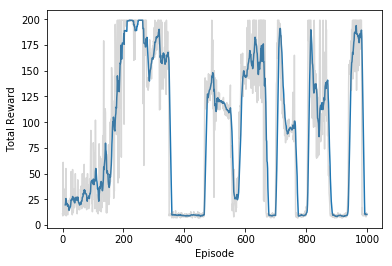

In [18]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

Text(0,0.5,'Training Loss')

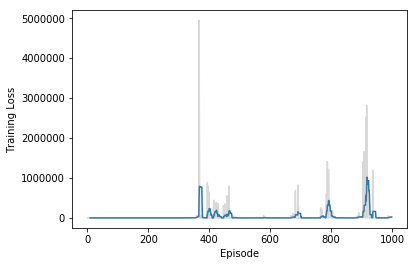

In [19]:
eps, loss = np.array(loss_list).T
smoothed_loss = running_mean(loss, 10)
plt.plot(eps[-len(smoothed_loss):], smoothed_loss)
plt.plot(eps, loss, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Training Loss')

## Testing

Let's checkout how our trained agent plays the game.

In [20]:
test_episodes = 10
test_max_steps = 400
env.reset()
with tf.Session() as sess:
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    # Restore/load the trained model 
    saver.restore(sess, "checkpoints/DQN-cartpole.ckpt")
    
    # Training episodes/ epochs
    for ep in range(test_episodes):
        
        # Env/Rob steps for minibatches/batches training
        t = 0
        while t < test_max_steps:
            # env.render() 
            
            # Get action from DQN
            feed_dict = {model.states: state.reshape((1, *state.shape))}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            # If episode is done/failed;
            if done:
                t = test_max_steps
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/DQN-cartpole.ckpt


In [21]:
env.close()

## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.